# Golf Game Improvement Model


**Overview :**

How well a player scores in golf is based on his/her skills in various parts of the game. It takes practice with a specific purpose in mind to score better. This data project will give users specific areas to practice in order to reach a specific goal, helping people improve their games.

**Function :**

- Input: Score
- Output: Greens, Putts, Fairways

**Definitions :**

- Score (INT): The total number of shots taken in the round.
- Greens (INT): The number of greens in regulation (out of 18). [More Info](https://www.liveabout.com/what-is-green-in-regulation-gir-1560864)
- Putts (INT): The total number of putts taken in the round.
- Fairways (INT): The total number of fairways hit in a round (out of 14 assuming a course with 14 fairways)

### Personal Data

Each record in my data set represents a round of golf that I played and includes details about that round such as the score and stats (e.g. number of putts, number of fairways). I cleaned the data below...

In [2]:
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [131]:
# Import Round Data
round_data = pd.read_csv('./data/rounds.csv', usecols=["Name", "Date", "Course", "Course Rating"])
round_data.columns = ['Rounds', 'Date', 'Course', 'Course Rating']
round_data['Date'] = pd.to_datetime(round_data['Date'])

# Import Hole Data
hole_data = pd.read_csv('./data/holes.csv')
hole_data['Greens'] = hole_data['Greens'].map({'checked': '1'})
hole_data['Greens'] = hole_data['Greens'].astype('float64')
hole_data['Sand'] = hole_data['Sand'].map({'Y': '1', 'N': '0'})
hole_data['Sand'] = hole_data['Sand'].astype('float64')
hole_data['Scrambling'] = hole_data['Scrambling'].map({'Y': '1', 'N': '0'})
hole_data['Scrambling'] = hole_data['Scrambling'].astype('float64')
hole_data['Fairways'] = hole_data['Fairways'].map({'Y': '1', 'N': '0'})
hole_data['Fairways'] = hole_data['Fairways'].astype('float64')

# Create Scores Summary Table
scores_summary = hole_data.groupby(['Rounds'])[['Par', 'Score', 'Putts', 'Fairways', 'Greens']].sum()
holes_played = hole_data['Rounds'].value_counts()
relative_score = scores_summary.Score - scores_summary.Par
relative_score.sort_index(inplace = True)
relative_score.index = holes_played.index - 1
holes_played.sort_index(inplace = True)
holes_played.index = holes_played.index - 1
scores_summary = round_data.merge(scores_summary, on='Rounds')
scores_summary['Holes Played'] = holes_played
scores_summary['Relative Score'] = relative_score

#Remove records without stats tracked
scores_summary.drop([3,5], inplace=True)
scores_summary.reset_index(inplace=True)
scores_summary.drop(['index','Rounds'], inplace=True, axis=1)

#Combine 9 hole scores
s1 = scores_summary.iloc[1,4:]
s2 = scores_summary.iloc[11,4:]
s2a = scores_summary.iloc[11,:4]
s = s1 + s2
scores_summary.iloc[11] = s2a.append(s)
scores_summary.drop([1], inplace=True)

# Add column for relative score given course difficulty
scores_summary['Relative Score w/ Rating'] = scores_summary.Score.astype('float64') - scores_summary['Course Rating']

scores_summary.head()

,Date,Course,Course Rating,Par,Score,Putts,Fairways,Greens,Holes Played,Relative Score,Relative Score w/ Rating
0,2019-07-20,Wilshire Country Club,71.8,71,98,34.0,5.0,4.0,18,9,26.2
2,2019-07-27,Wilshire Country Club,71.8,71,98,33.0,10.0,3.0,18,20,26.2
3,2019-06-16,Sandpiper,75.1,72,86,32.0,5.0,4.0,18,15,10.9
4,2019-08-17,Wilshire Country Club,71.8,71,91,29.0,5.0,0.0,18,18,19.2
5,2019-08-24,Wilshire Country Club,71.8,71,83,28.0,5.0,4.0,18,12,11.2


**Scores Plotted Over Time**

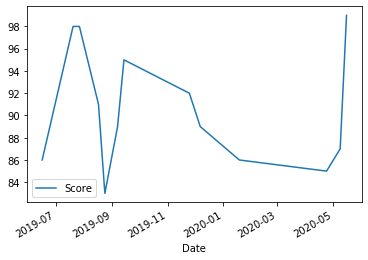

In [123]:
scores_summary.plot(x="Date", y="Score")

**Distribution of Scores**

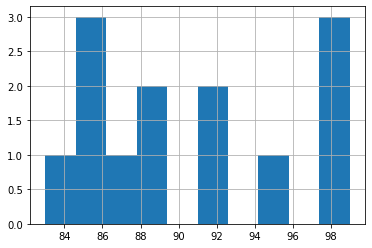

In [5]:
# Distribution of scores
scores_summary['Score'].hist()

**Average Stats Given Score Ranges**

In [126]:
def find_stats(input_score):
    df = scores_summary[(scores_summary["Score"] > input_score) & (scores_summary["Score"] < input_score + 10) & (scores_summary["Holes Played"] == 18)]
    df = pd.DataFrame(df[['Putts','Fairways','Greens']].mean())
    df.columns = [str(input_score) + 's']
    return df

shoot_80s = find_stats(input_score = 80)
shoot_90s = find_stats(input_score = 90)
shoot_80s.merge(shoot_90s, left_index=True, right_index = True)

,80s,90s
Putts,30.571429,34.000000
Fairways,5.857143,5.833333
Greens,4.000000,3.166667


**Correlation Matrix of Scores and Stats**

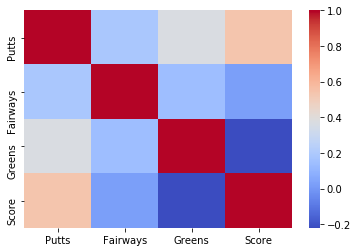

In [8]:
correlations = scores_summary[["Putts", "Fairways", "Greens", "Score"]].corr()
sns.heatmap(correlations, cmap='coolwarm')

**Scatterplot: The Relationship Between Stats and Score**

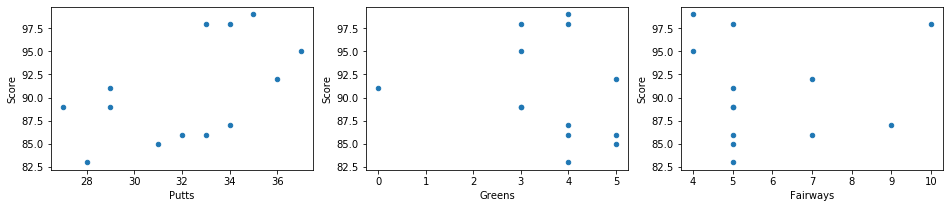

In [135]:
fig, axs = plt.subplots(1, 3, sharey=False)
scores_summary.plot(kind="scatter", x="Putts", y="Score", ax=axs[0], figsize=(16, 3))
scores_summary.plot(kind="scatter", x="Greens", y="Score", ax=axs[1], figsize=(16, 3))
scores_summary.plot(kind="scatter", x="Fairways", y="Score", ax=axs[2], figsize=(16, 3))

### PGA Tour Data

Using a publically available dataset with the stats and average scores for professional golfers could be a way of expanding my dataset. Each record in this PGA Tour dataset represents a player and a summary of statistics for all the rounds they played between 2010 and 2018.

In [132]:
# Import PGA Tour Data
data = pd.read_csv('./data/pgaTourData.csv')

# Remove NA records.
cleaned_data = data[data['gir'].notna()]

# Remove unecessary features
cleaned_data = cleaned_data[['gir','Average Putts','Average Score','Fairway Percentage']]

# Convert average percentages per round into averages totals per round 
cleaned_data['gir'] = (cleaned_data['gir']/100)*18
cleaned_data['Fairway Percentage'] = (cleaned_data['Fairway Percentage']/100)*14
cleaned_data['Holes Played'] = 18

# Rename columns
cleaned_data.columns = ['Greens','Putts','Score','Fairways','Holes Played']

cleaned_data.head()

,Greens,Putts,Score,Fairways,Holes Played
0,13.2318,29.93,69.617,10.5266,18
1,12.2796,29.31,70.758,10.3012,18
2,12.3606,29.12,70.432,10.1136,18
3,12.3840,29.17,70.015,10.0716,18
4,12.0816,29.11,71.038,10.0016,18


**Distribution of Scores**

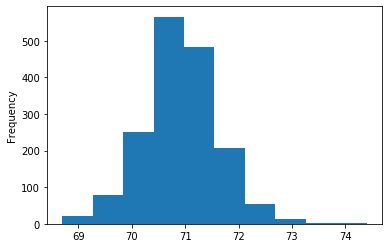

In [12]:
cleaned_data['Score'].plot(kind='hist')

**Average Stats Given Scores**

In [111]:
def find_avg_stats(score):
    stats = cleaned_data[(cleaned_data['Score'] >= score) & (cleaned_data['Score'] < (score+1))].mean()
    return stats.rename(score)

attributes = pd.DataFrame()
for i in range(69,75):
    stats = find_avg_stats(i)
    attributes = attributes.append(stats)
    
attributes

,Fairways,Greens,Holes Played,Putts,Score
69,8.668312,12.181105,18.0,28.902197,69.676947
70,8.689830,11.945433,18.0,29.111790,70.601705
71,8.527404,11.660652,18.0,29.246195,71.385104
72,8.320646,11.344292,18.0,29.486923,72.297560
73,8.132400,10.861457,18.0,29.327143,73.219714
74,6.187300,9.720000,18.0,28.905000,74.331000


### Adding Pro Scores to My Scores

By adding in average stats for professional golfers, I can create a more robust model that works for my scores as well as the low scores that professionals shoot, and hopefully the scores in between too.

In [137]:
new = pd.DataFrame()
for i in range(70,75):
    test = cleaned_data[(cleaned_data['Score'] >= i) & (cleaned_data['Score'] < (i+1))].sample(n=2, random_state=24)
    new = new.append(test, ignore_index = True)
scores_summary_added_pros = pd.concat([scores_summary,new])

**Scatterplot: The Relationship Between Stats and Score**

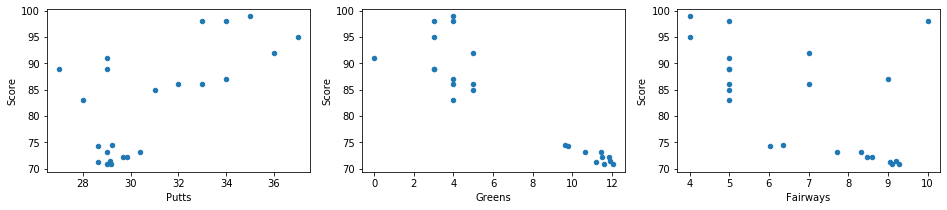

In [136]:
fig, axs = plt.subplots(1, 3, sharey=False)
scores_summary_added_pros.plot(kind="scatter", x="Putts", y="Score", ax=axs[0], figsize=(16, 3))
scores_summary_added_pros.plot(kind="scatter", x="Greens", y="Score", ax=axs[1], figsize=(16, 3))
scores_summary_added_pros.plot(kind="scatter", x="Fairways", y="Score", ax=axs[2], figsize=(16, 3))

### Applying a Linear Model

Understand the linear relationship between putts, greens, and fairways, with a target variable of score.

In [152]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

In [157]:
def fit_and_score_linear_model(df,target,model='linear'):

    features = ['Putts','Fairways','Greens']
    X = df[features]
    y = df[target]
    
    lr = LinearRegression()
    lr.fit(X,y)
    y_pred = lr.predict(X)
    r2 = lr.score(X,y)
    coefficients = lr.coef_
    intercept = lr.intercept_
    frame = pd.DataFrame({'Original': y,'Predicted': y_pred})
    model = lr
    
    print('coeffs:'+str(coefficients))
    print('intercept:'+str(intercept))
    print('r2:'+str(r2))
    
    return {'model':model, 'vals': frame,'score': r2, 'coeffs': coefficients}

In [158]:
test1 = fit_and_score_linear_model(scores_summary,'Score','linear')

coeffs:[ 1.25041109 -0.11996913 -1.98723359]
intercept:58.29583056169011
r2:0.5005286435494004


In [159]:
test2 = fit_and_score_linear_model(scores_summary_added_pros,'Score','linear')

coeffs:[ 1.23777615 -0.06265284 -1.91760438]
intercept:58.10202779759855
r2:0.9205079679115369


In [160]:
test3 = fit_and_score_linear_model(scores_summary,'Relative Score w/ Rating','linear')

coeffs:[ 1.35318548 -0.18625921 -2.00997446]
intercept:-15.885156320676888
r2:0.509141104502872


In [178]:
IDEAL_MODEL = test2['model']

The best performing model uses the data that has pro scores included. The coefficients from the linear model can be used to create an equation that predicts the score based on the number of putts, fairways, and greens. The number of greens hit has the biggest impact on overall score.

$$y = 1.2p - .06f - 1.9g + 58$$

### Applying a Random Forest Regressor

Generate a random forest of decision trees to understand the relationship between putts, greens, and fairways, with a target variable of score.

In [171]:
features = ['Putts','Fairways','Greens']
target = 'Score'
X = scores_summary[features]
y = scores_summary[target]

rf = RandomForestRegressor()
lr = LinearRegression()
kf = KFold(n_splits = 5)

scores = cross_val_score(lr,X,y,scoring='neg_mean_squared_error',cv=kf)
print('mse: ' + str(np.mean(-scores)))
scores = cross_val_score(rf,X,y,scoring='r2',cv=kf)
print('r2: ' + str(np.mean(scores)))

mse: 40.196480000249856
r2: -0.17128196886447014


### Output and Optimization

There are a few ways to use the model in order to generate a prediction. You can use the linear equation to solve for the target score given a specific stats. Or you can provide a range for each stat and use an optimization algorithm to predict the lowest score possible.


In [198]:
putts = 30.0
fairways = 6.0
greens = 10.0

In [199]:
IDEAL_MODEL.predict(pd.DataFrame({'Putts': [putts],'Fairways': [fairways],'Greens': [greens]}))[0]

75.68335154065976

In [202]:
from scipy.optimize import linprog

c = IDEAL_MODEL.coef_
putts_bounds = (18,60)
fairways_bounds = (0,18)
greens_bounds = (0,18)
result = linprog(c,  bounds=[putts_bounds, fairways_bounds, greens_bounds])
output = result.fun + IDEAL_MODEL.intercept_
output

44.73736863884062